In [1]:
!pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
import torch

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Object Detection Model: Faster R-CNN
Choose a model from https://pytorch.org/vision/stable/models/faster_rcnn.html

In [3]:
from torchvision.models.detection import (
    fasterrcnn_mobilenet_v3_large_fpn,
    FasterRCNN_MobileNet_V3_Large_FPN_Weights,
)

NUM_CLASSES = 2  # background=0 included


def get_faster_rcnn_model(num_classes):
    """return model and preprocessing transform"""
    model = fasterrcnn_mobilenet_v3_large_fpn(
        weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT
    )
    model.roi_heads.box_predictor.cls_score = torch.nn.Linear(
        in_features=model.roi_heads.box_predictor.cls_score.in_features,
        out_features=num_classes,
        bias=True,
    )
    model.roi_heads.box_predictor.bbox_pred = torch.nn.Linear(
        in_features=model.roi_heads.box_predictor.bbox_pred.in_features,
        out_features=num_classes * 4,
        bias=True,
    )
    preprocess = FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT.transforms()
    return model, preprocess


model, preprocess = get_faster_rcnn_model(num_classes=NUM_CLASSES)
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

# CocoDataset
The torchvision CocoDetection dataset is currently not compatible with the official COCO format (https://cocodataset.org/#format-data), which is why we need to define a custom CocoDataset class

In [4]:
import json
from collections import defaultdict
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset


class CocoDataset(Dataset):
    """PyTorch dataset for COCO annotations."""

    # adapted from https://github.com/pytorch/vision/issues/2720

    def __init__(self, root, annFile, transform=None):
        """Load COCO annotation data."""
        self.data_dir = Path(root)
        self.transform = transform

        # load the COCO annotations json
        anno_file_path = annFile
        with open(str(anno_file_path)) as file_obj:
            self.coco_data = json.load(file_obj)
        # put all of the annos into a dict where keys are image IDs to speed up retrieval
        self.image_id_to_annos = defaultdict(list)
        for anno in self.coco_data["annotations"]:
            image_id = anno["image_id"]
            self.image_id_to_annos[image_id] += [anno]

    def __len__(self):
        return len(self.coco_data["images"])

    def __getitem__(self, index):
        """Return tuple of image and labels as torch tensors."""
        image_data = self.coco_data["images"][index]
        image_id = image_data["id"]
        image_path = self.data_dir / image_data["file_name"]
        image = Image.open(image_path)

        annos = self.image_id_to_annos[image_id]
        anno_data = {
            "boxes": [],
            "labels": [],
            "area": [],
            "iscrowd": [],
        }
        for anno in annos:
            coco_bbox = anno["bbox"]
            left = coco_bbox[0]
            top = coco_bbox[1]
            right = coco_bbox[0] + coco_bbox[2]
            bottom = coco_bbox[1] + coco_bbox[3]
            area = coco_bbox[2] * coco_bbox[3]
            anno_data["boxes"].append([left, top, right, bottom])
            anno_data["labels"].append(anno["category_id"])
            anno_data["area"].append(area)
            anno_data["iscrowd"].append(anno["iscrowd"])

        target = {
            "boxes": torch.as_tensor(anno_data["boxes"], dtype=torch.float32),
            "labels": torch.as_tensor(anno_data["labels"], dtype=torch.int64),
            "image_id": torch.tensor([image_id]),
            "area": torch.as_tensor(anno_data["area"], dtype=torch.float32),
            "iscrowd": torch.as_tensor(anno_data["iscrowd"], dtype=torch.int64),
        }

        if self.transform is not None:
            image = self.transform(image)

        return image, target

## Test the dataset
I created a synthetic training and validation dataset in the COCO format using https://github.com/ignc-research/blender-gen

training dataset size: 50
validation dataset size: 10
tensor([[[0.6902, 0.7020, 0.7098,  ..., 0.6078, 0.7843, 0.7961],
         [0.6941, 0.6784, 0.6784,  ..., 0.6431, 0.8118, 0.8078],
         [0.6863, 0.6902, 0.6863,  ..., 0.6863, 0.8000, 0.8039],
         ...,
         [0.5294, 0.5765, 0.5882,  ..., 0.8078, 0.8078, 0.8118],
         [0.5529, 0.5882, 0.5765,  ..., 0.8118, 0.8078, 0.8039],
         [0.5373, 0.5922, 0.5804,  ..., 0.8078, 0.8078, 0.8078]],

        [[0.6941, 0.7059, 0.7137,  ..., 0.6157, 0.7843, 0.7961],
         [0.6980, 0.6824, 0.6824,  ..., 0.6510, 0.8118, 0.8078],
         [0.6863, 0.6902, 0.6824,  ..., 0.6941, 0.8000, 0.8039],
         ...,
         [0.4980, 0.5451, 0.5569,  ..., 0.8078, 0.8078, 0.8118],
         [0.5137, 0.5490, 0.5373,  ..., 0.8118, 0.8078, 0.8039],
         [0.4980, 0.5529, 0.5412,  ..., 0.8078, 0.8078, 0.8078]],

        [[0.7098, 0.7216, 0.7294,  ..., 0.6039, 0.7843, 0.7961],
         [0.7137, 0.6980, 0.6980,  ..., 0.6392, 0.8118, 0.8078],
    

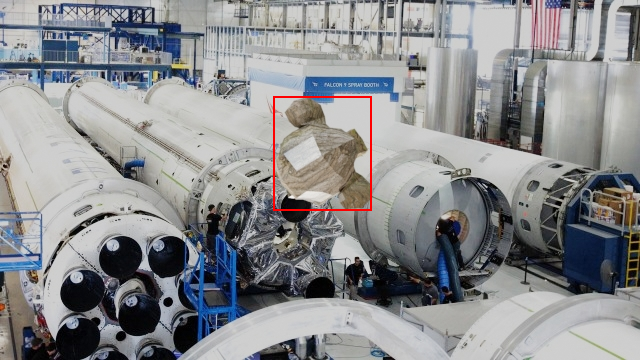

In [14]:
import torchvision.transforms as T
import random
from IPython.display import display  # to display images
from PIL import ImageDraw

# create datasets
training_dataset = CocoDataset(
    root="./data/train/images/",
    annFile="./data/train/annotations/instances_default.json",
    transform=preprocess,
)
validation_dataset = CocoDataset(
    root="./data/validation/images/",
    annFile="./data/validation/annotations/instances_default.json",
    transform=preprocess,
)

print(f"training dataset size: {training_dataset.__len__()}")
print(f"validation dataset size: {validation_dataset.__len__()}")

# get a random training sample
img, label = training_dataset[random.randint(0, len(training_dataset) - 1)]
print(img)
print(f"random training label: {label}")

# display image with bbox label
transform = T.ToPILImage()
img = transform(img)
x1, y1, x2, y2 = label["boxes"].numpy()[0]
draw = ImageDraw.Draw(img)
draw.rectangle([x1, y1, x2, y2], fill=None, outline="#ff0000cc", width=2)
display(img)

# DataLoader
The DataLoader returns batches of data during training and validation

In [6]:
def collate(batch):
    """return tuple data"""
    return tuple(zip(*batch))


BATCH_SIZE = 4
train_loader = torch.utils.data.DataLoader(
    training_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    collate_fn=collate,
)

validation_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate,
)

test the model with a validation batch as input

In [7]:
# get a validation batch
X, y = next(iter(validation_loader))

model.eval()
with torch.no_grad():
    X = [x.to(device) for x in X]
    out = model(X)
    print(out)

[{'boxes': tensor([[4.3257e+02, 1.7866e+02, 4.8162e+02, 1.9539e+02],
        [1.1252e+02, 2.1096e+02, 1.2259e+02, 2.1724e+02],
        [1.2005e+02, 1.8161e+02, 1.2397e+02, 1.9263e+02],
        [5.8135e+02, 1.8532e+02, 5.8619e+02, 1.9306e+02],
        [2.1062e+02, 1.7456e+02, 2.5880e+02, 2.0138e+02],
        [1.1434e+02, 2.0874e+02, 1.2316e+02, 2.1590e+02],
        [4.2531e+02, 2.0951e+02, 4.3677e+02, 2.1586e+02],
        [5.6701e+02, 1.8424e+02, 5.7115e+02, 1.9258e+02],
        [4.0082e+02, 1.7168e+02, 4.3155e+02, 1.9550e+02],
        [4.4508e+01, 1.6833e+02, 4.7808e+01, 1.7982e+02],
        [7.0037e+01, 1.8595e+02, 8.9772e+01, 2.0988e+02],
        [1.1805e+02, 2.0765e+02, 1.2489e+02, 2.1457e+02],
        [2.8288e+02, 1.7807e+02, 3.0649e+02, 1.9712e+02],
        [4.0347e+02, 1.7199e+02, 4.9050e+02, 1.9945e+02],
        [2.0908e+02, 1.4616e+02, 2.1789e+02, 1.6124e+02],
        [4.7952e+02, 1.6995e+02, 5.9561e+02, 2.0051e+02],
        [4.4194e+02, 1.8411e+02, 4.4949e+02, 1.9547e+02],
   

# Model Training

epoch: 0
train loss: 0.2776359021663666, validation loss: 0.28950902819633484
epoch: 1
train loss: 0.2550429403781891, validation loss: 0.26295432448387146
epoch: 2
train loss: 0.23436403274536133, validation loss: 0.23277664184570312
epoch: 3
train loss: 0.21442145109176636, validation loss: 0.2272319793701172
epoch: 4
train loss: 0.19904401898384094, validation loss: 0.21083031594753265
epoch: 5
train loss: 0.18614082038402557, validation loss: 0.19637475907802582
epoch: 6
train loss: 0.17686954140663147, validation loss: 0.1878158152103424
epoch: 7
train loss: 0.16795413196086884, validation loss: 0.1783984899520874
epoch: 8
train loss: 0.1595190316438675, validation loss: 0.16802875697612762
epoch: 9
train loss: 0.1529342085123062, validation loss: 0.16784165799617767
epoch: 10
train loss: 0.148670494556427, validation loss: 0.15251390635967255
epoch: 11
train loss: 0.14342159032821655, validation loss: 0.15079045295715332
epoch: 12
train loss: 0.14007817208766937, validation loss:

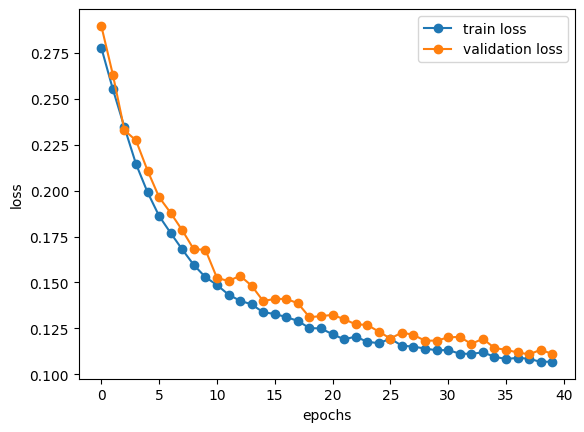

In [8]:
import matplotlib.pyplot as plt

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.00001, momentum=0.9, weight_decay=0.0001)

num_epochs = 40

train_loss_list = []
validation_loss_list = []
model.train()
for epoch in range(num_epochs):
    N = len(train_loader.dataset)
    current_train_loss = 0
    # train loop
    for images, targets in train_loader:
        # move data to device and build the right input format for our model
        images = list(image.to(device) for image in images)
        targets = [
            {
                k: v.to(device) if isinstance(v, torch.Tensor) else v
                for k, v in t.items()
            }
            for t in targets
        ]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        current_train_loss += losses
    train_loss_list.append(current_train_loss / N)

    # validation loop
    N = len(validation_loader.dataset)
    current_validation_loss = 0
    with torch.no_grad():
        for images, targets in validation_loader:
            images = list(image.to(device) for image in images)
            targets = [
                {
                    k: v.to(device) if isinstance(v, torch.Tensor) else v
                    for k, v in t.items()
                }
                for t in targets
            ]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            current_validation_loss += losses
    validation_loss_list.append(current_validation_loss / N)

    print(f"epoch: {epoch}")
    print(
        f"train loss: {train_loss_list[-1]}, validation loss: {validation_loss_list[-1]}"
    )

torch.save(model, "./models/model.pth")

# plot losses
train_loss = [x.cpu().detach().numpy() for x in train_loss_list]
validation_loss = [x.cpu().detach().numpy() for x in validation_loss_list]

plt.plot(train_loss, "-o", label="train loss")
plt.plot(validation_loss, "-o", label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

# Inference
use the trained model to predict a bounding box on an image

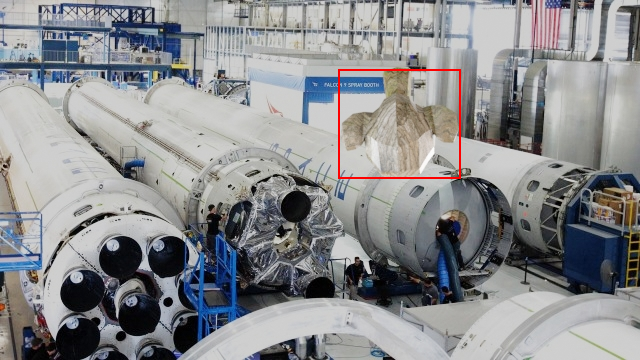

[{'boxes': tensor([[338.1157,  69.1257, 460.6765, 178.7086],
          [368.8213,  72.9358, 428.4148, 169.8269],
          [353.6605, 256.2807, 363.3483, 273.2455],
          [359.8295, 255.5448, 375.3475, 276.8574],
          [347.1815, 249.9553, 366.3625, 278.5979],
          [ 47.8757, 159.0891, 160.8058, 346.6056],
          [431.9269, 202.4223, 465.6588, 289.8130],
          [355.1431, 262.9963, 376.8282, 294.6366],
          [ 62.3939, 271.4976,  97.5942, 307.9228],
          [360.4022, 268.7760, 372.9895, 283.3462],
          [115.4173, 260.6339, 159.0728, 331.5397],
          [349.2794, 256.6001, 359.5898, 276.8493],
          [348.1577, 252.6436, 390.1019, 302.1666],
          [435.1348, 219.7688, 458.1127, 283.8867],
          [118.7809, 287.7799, 155.2810, 325.2605],
          [362.6965, 257.0711, 372.3140, 273.1644],
          [348.6246, 263.6436, 359.6702, 284.7906],
          [  9.6266, 115.8922, 396.4325, 335.7324],
          [100.4424, 232.3439, 195.6188, 341.1343],
   

In [12]:
img, _ = validation_dataset[random.randint(0, len(validation_dataset) - 1)]
model = torch.load("./models/model.pth")


def inference(img, device, model):
    model.eval()
    with torch.no_grad():
        pred = model([img.to(device)])

    # display image with bbox
    transform = T.ToPILImage()
    img = transform(img)
    x1, y1, x2, y2 = pred[0]["boxes"].cpu().detach().numpy()[0]
    draw = ImageDraw.Draw(img)
    draw.rectangle([x1, y1, x2, y2], fill=None, outline="#ff0000cc", width=2)
    display(img)
    return pred


inference(img, device, model)